In [16]:
# 기본 라이브러리
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 전처리
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 모델 학습 및 평가
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    root_mean_squared_error
)
from xgboost import XGBRegressor, XGBClassifier

# 시각화 라이브러리
import seaborn as sns

# Statsmodels 및 생존 분석
import statsmodels.api as sm
from lifelines import CoxPHFitter

# PCA 및 SHAP
from sklearn.decomposition import PCA
import shap

seed = 42
# numpy
np.random.seed(seed)
# pandas
random.seed(seed)
# 파이썬 hash seed 고정
os.environ["PYTHONHASHSEED"] = str(seed)

df = pd.read_csv('data/telematics_data.csv')

### 데이터 준비

In [2]:
preprocessed_df = df.copy()

In [3]:
categorical_cols = [
    'Insured.sex', 
    'Marital', 
    'Car.use', 
    'Region', 
    # 'Territory'  # 숫자로 되어있긴 하나, 범주형
]

numerical_cols = [
    'Territory',
    'Duration', 'Insured.age', 'Car.age', 'Credit.score', 
    'Annual.miles.drive', 'Years.noclaims', 'Annual.pct.driven', 
    'Total.miles.driven', 
    'Pct.drive.mon', 'Pct.drive.tue', 'Pct.drive.wed', 'Pct.drive.thr', 
    'Pct.drive.fri', 'Pct.drive.sat', 'Pct.drive.sun', 
    'Pct.drive.2hrs', 'Pct.drive.3hrs', 'Pct.drive.4hrs', 
    'Pct.drive.wkday', 'Pct.drive.wkend', 'Pct.drive.rush am', 'Pct.drive.rush pm', 
    'Avgdays.week', 
    'Accel.06miles', 'Accel.08miles', 'Accel.09miles', 'Accel.11miles', 
    'Accel.12miles', 'Accel.14miles', 
    'Brake.06miles', 'Brake.08miles', 'Brake.09miles', 'Brake.11miles', 
    'Brake.12miles', 'Brake.14miles', 
    'Left.turn.intensity08', 'Left.turn.intensity09', 'Left.turn.intensity10', 
    'Left.turn.intensity11', 'Left.turn.intensity12', 
    'Right.turn.intensity08', 'Right.turn.intensity09', 'Right.turn.intensity10', 
    'Right.turn.intensity11', 'Right.turn.intensity12', 
    'NB_Claim', 'AMT_Claim'
]

### 전처리

In [4]:
X_labeled = df[categorical_cols].copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_labeled[col] = le.fit_transform(X_labeled[col])
X_numerical = df[numerical_cols]

X_label_encoded = pd.concat([X_labeled, X_numerical], axis=1).astype(float)

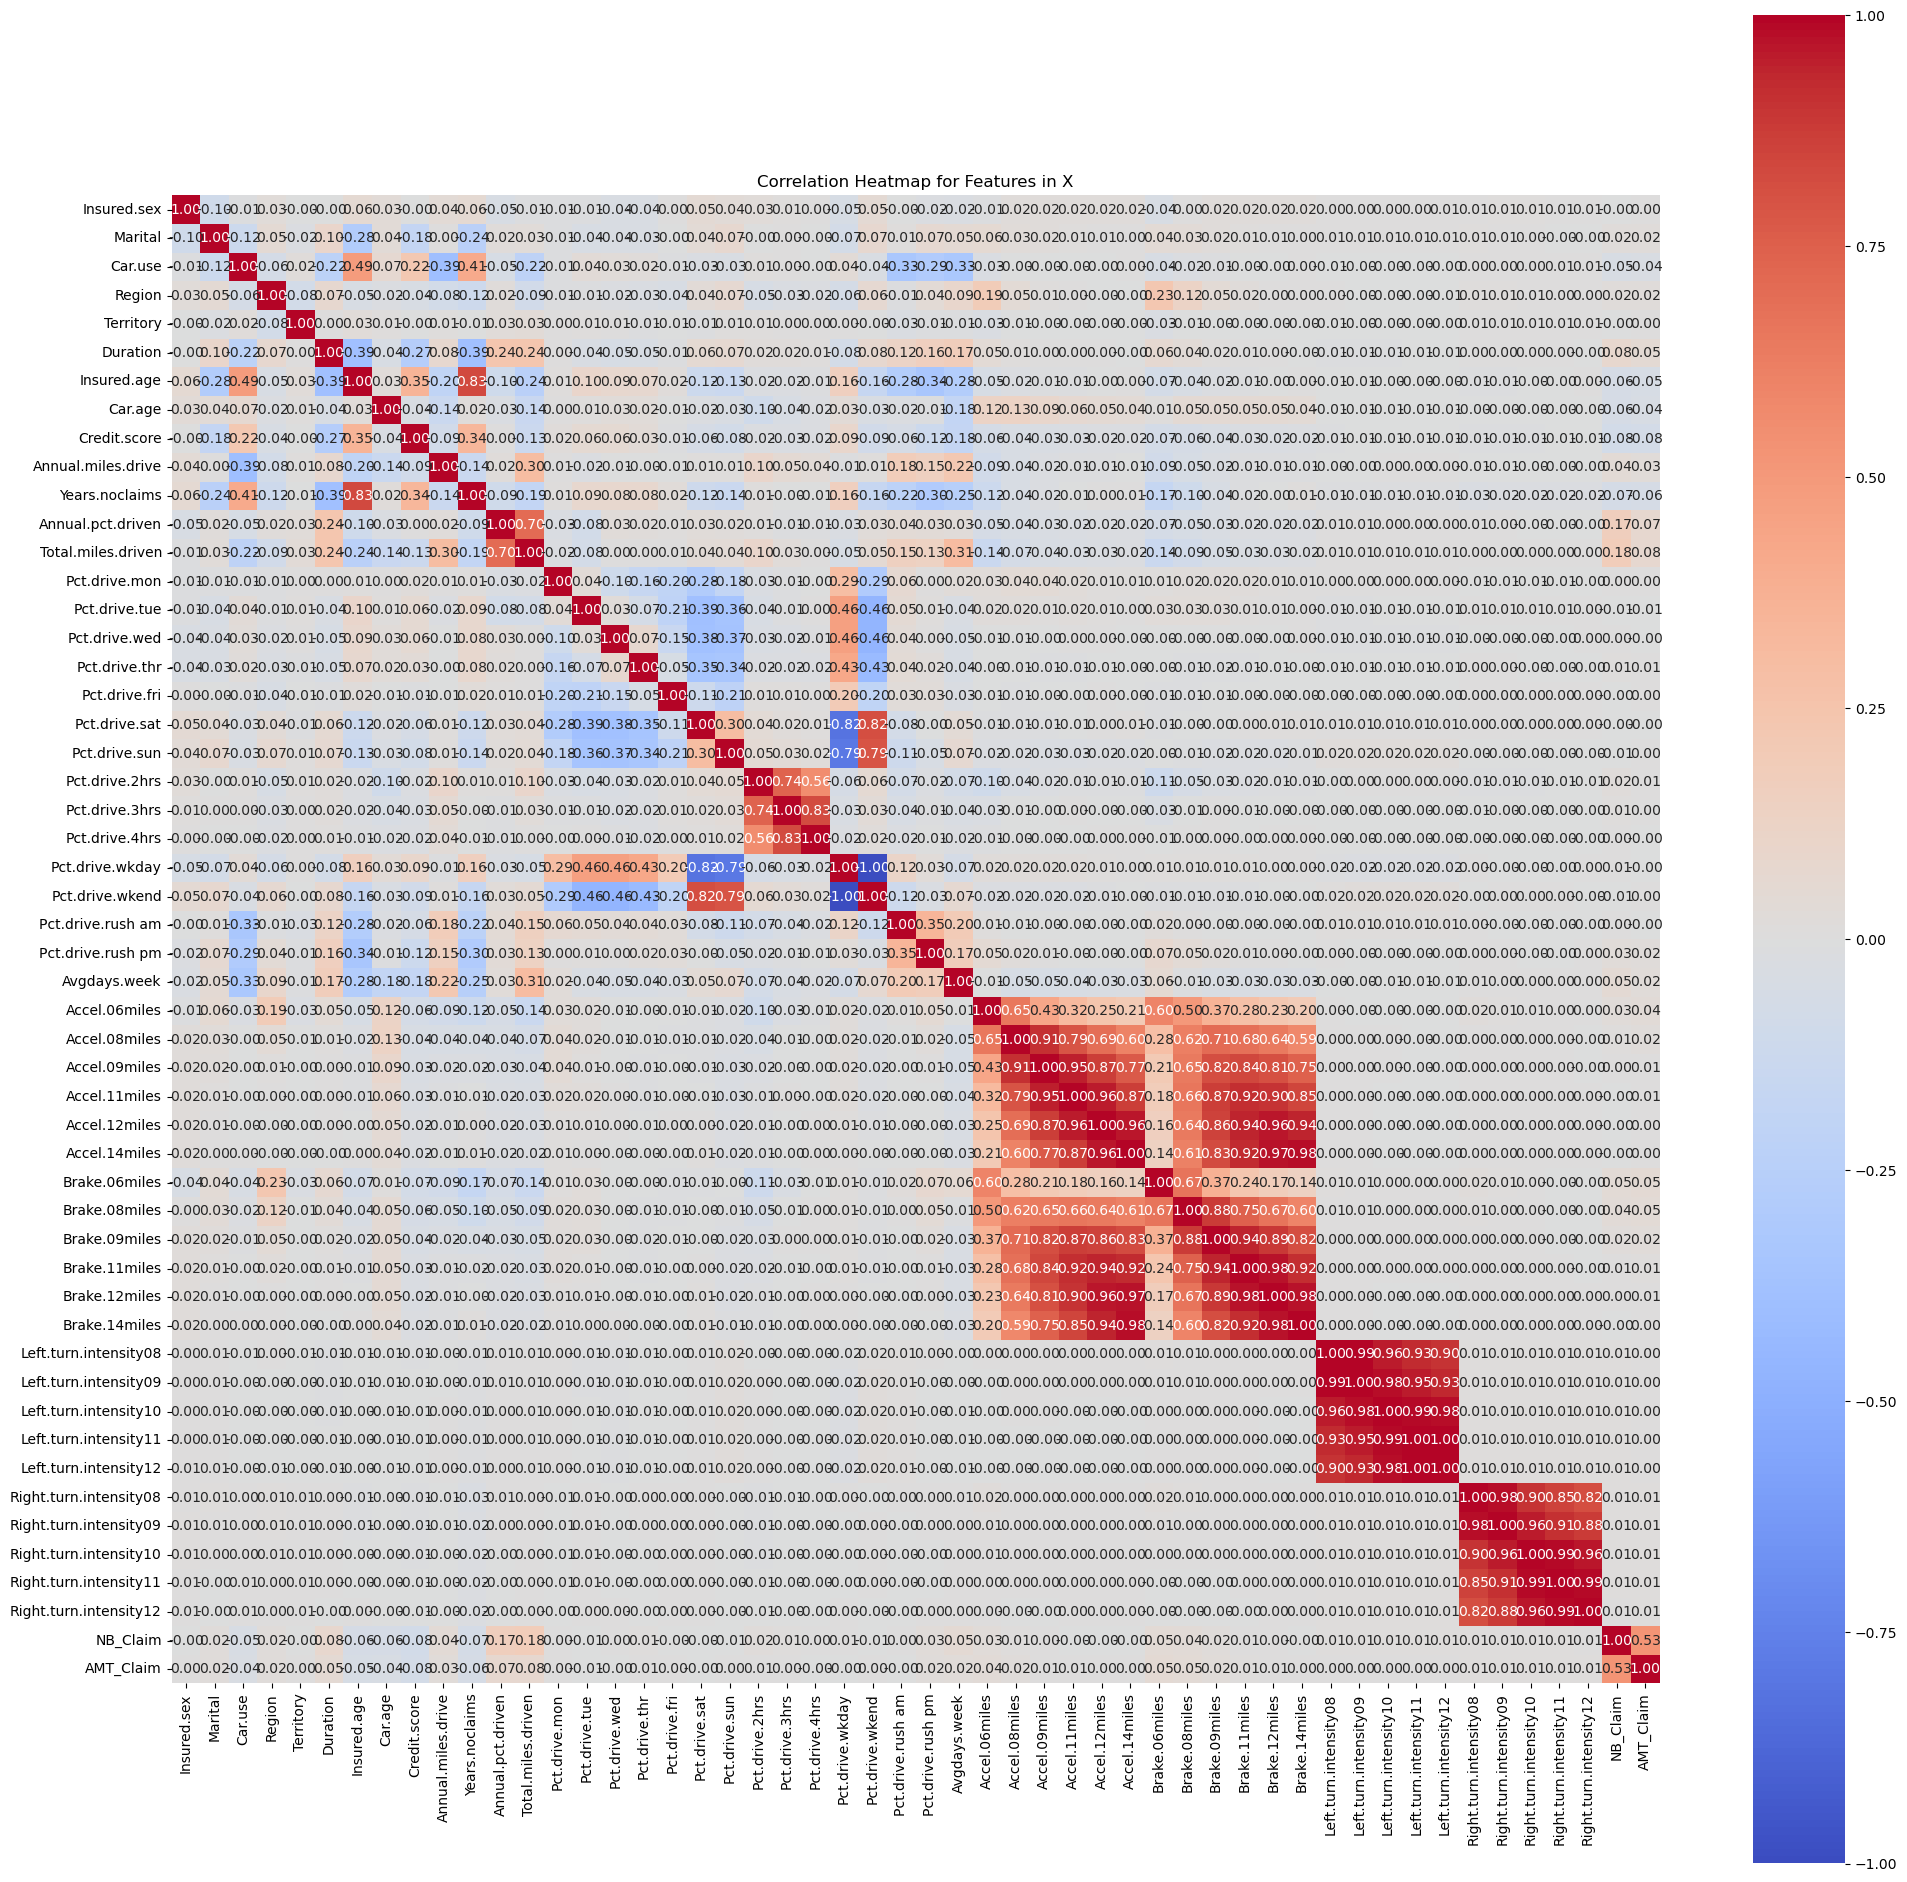

In [5]:
# 5️⃣ 상관 행렬 계산
correlation_matrix = X_label_encoded.corr()

# 히트맵 생성
plt.figure(figsize=(24, 24))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Heatmap for Features in X')
plt.show()

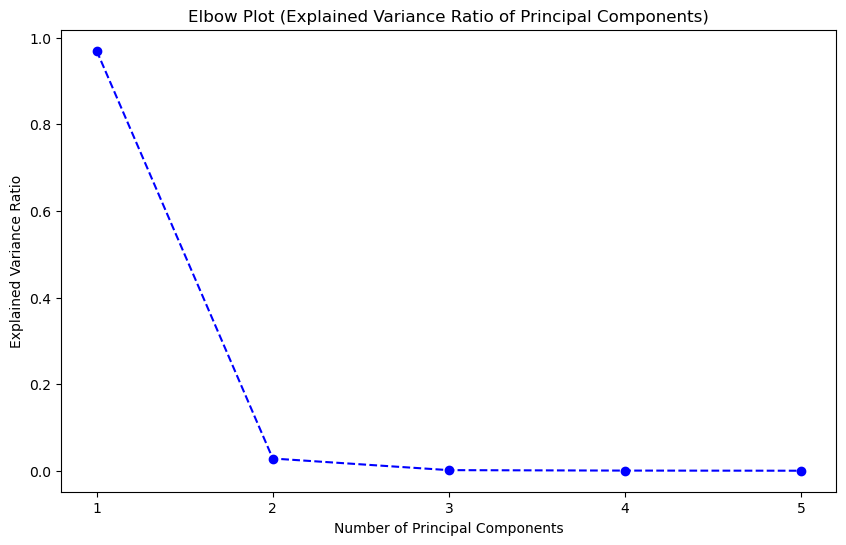

Principal Component 1: Explained Variance Ratio = 0.9697
Principal Component 2: Explained Variance Ratio = 0.0283
Principal Component 3: Explained Variance Ratio = 0.0014
Principal Component 4: Explained Variance Ratio = 0.0004
Principal Component 5: Explained Variance Ratio = 0.0001


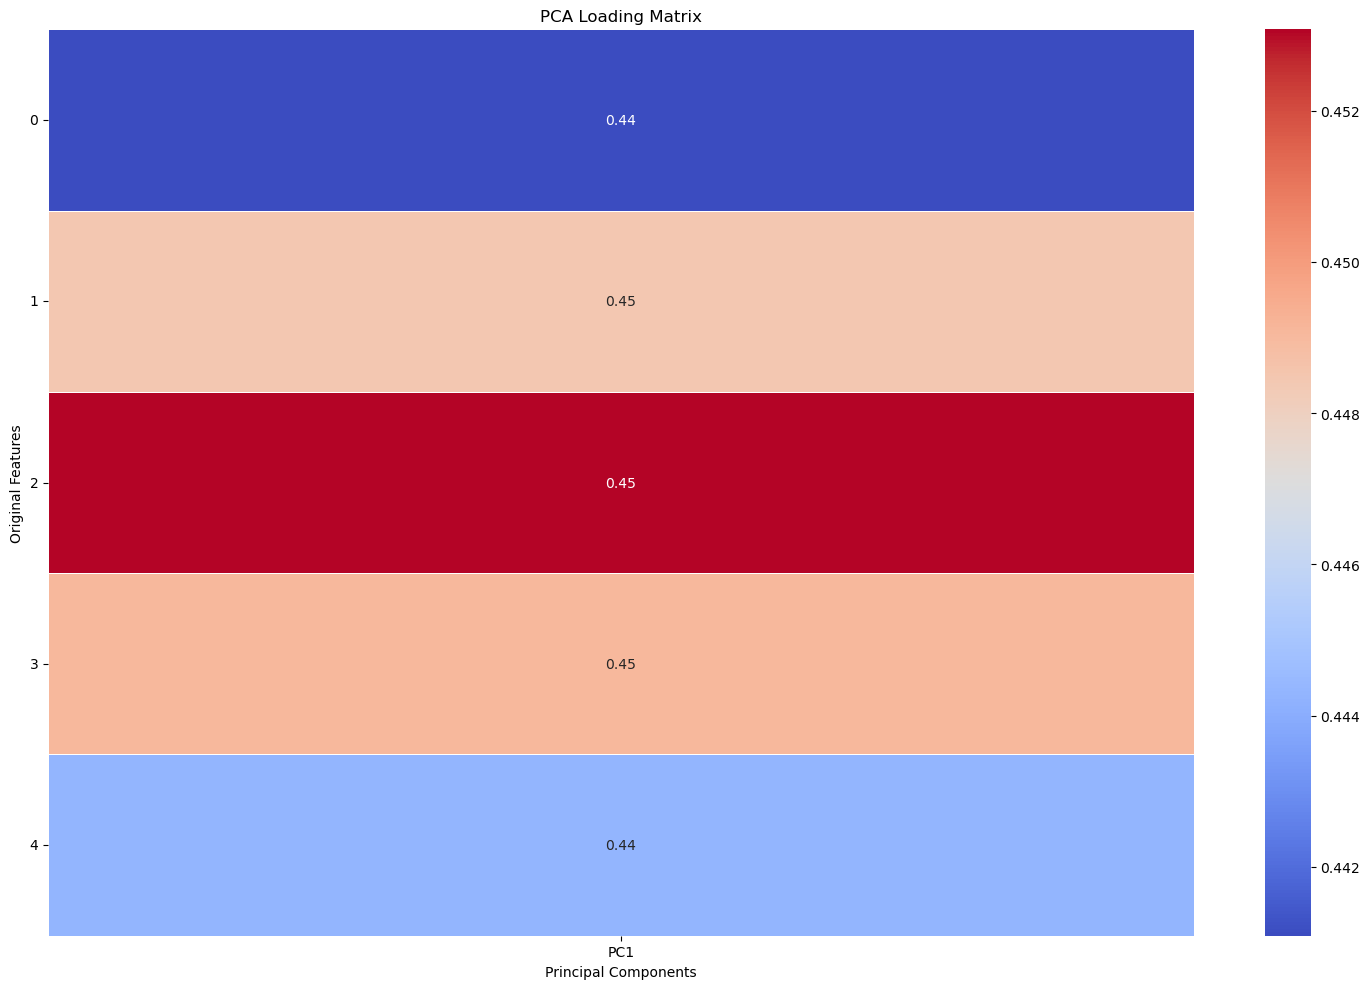

In [6]:
X_left_turn_intensity = df[['Left.turn.intensity08', 'Left.turn.intensity09', 'Left.turn.intensity10', 'Left.turn.intensity11', 'Left.turn.intensity12']]
scaler = StandardScaler()
X_left_turn_intensity = scaler.fit_transform(X_left_turn_intensity)

X_right_turn_intensity = df[['Right.turn.intensity08', 'Right.turn.intensity09', 'Right.turn.intensity10', 'Right.turn.intensity11', 'Right.turn.intensity12']]
scaler = StandardScaler()
X_right_turn_intensity = scaler.fit_transform(X_right_turn_intensity)

##########
# 📌 6️⃣ PCA 적용 (n_components를 지정하지 않고 모든 주성분을 사용)
pca = PCA()
X_pca = pca.fit_transform(X_left_turn_intensity)

# 📌 7️⃣ 설명된 분산 비율 (Explained Variance Ratio)
explained_variance_ratio = pca.explained_variance_ratio_

# 📌 8️⃣ Elbow Plot 생성 (아래로 볼록한 형태)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Plot (Explained Variance Ratio of Principal Components)')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

# 📌 9️⃣ 주성분별 설명 분산 비율 출력
for i, variance in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: Explained Variance Ratio = {variance:.4f}")

##########
# 📌 n_components로 PCA 다시 수행
n_components = 1
pca = PCA(n_components=n_components)
left_turn_intensity_col = pca.fit_transform(X_left_turn_intensity)
preprocessed_df['left_turn_intensity'] = left_turn_intensity_col.flatten()
preprocessed_df = preprocessed_df.drop(columns=['Left.turn.intensity08', 'Left.turn.intensity09', 'Left.turn.intensity10', 'Left.turn.intensity11', 'Left.turn.intensity12'])

# 📌 주성분 계수 (loading) 시각화
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(n_components)])

# 📌 히트맵 시각화 (주성분에 대한 변수의 기여도)
plt.figure(figsize=(15, 10))  # 그래프 크기 확대
sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title('PCA Loading Matrix')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.yticks(rotation=0)  # y축 피처 이름을 가로로 회전
plt.tight_layout()  # 여백 자동 조정
plt.show()

##########
# 📌 n_components로 PCA 다시 수행
n_components = 1
pca = PCA(n_components=n_components)
right_turn_intensity_col = pca.fit_transform(X_right_turn_intensity)
preprocessed_df['right_turn_intensity'] = right_turn_intensity_col.flatten()
preprocessed_df = preprocessed_df.drop(columns=['Right.turn.intensity08', 'Right.turn.intensity09', 'Right.turn.intensity10', 'Right.turn.intensity11', 'Right.turn.intensity12'])
# 📌 주성분 계수 (loading) 시각화
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(n_components)])

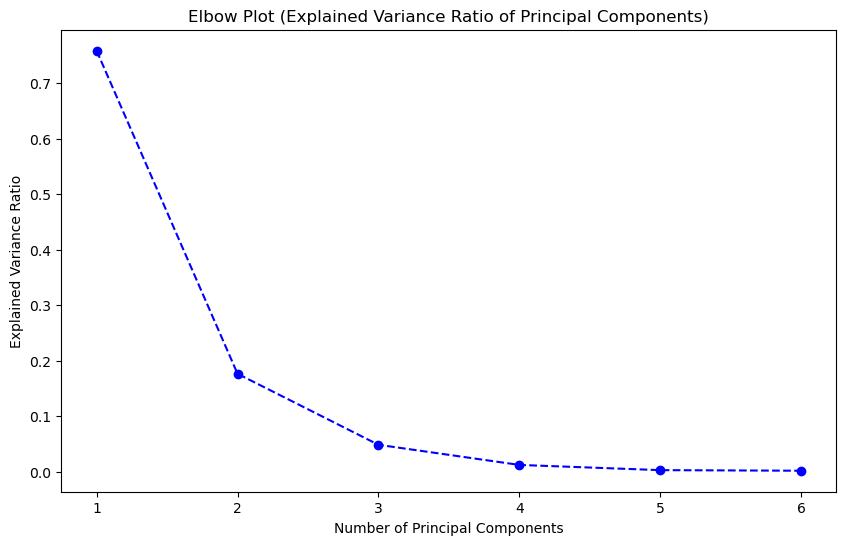

Principal Component 1: Explained Variance Ratio = 0.7580
Principal Component 2: Explained Variance Ratio = 0.1764
Principal Component 3: Explained Variance Ratio = 0.0485
Principal Component 4: Explained Variance Ratio = 0.0123
Principal Component 5: Explained Variance Ratio = 0.0029
Principal Component 6: Explained Variance Ratio = 0.0018


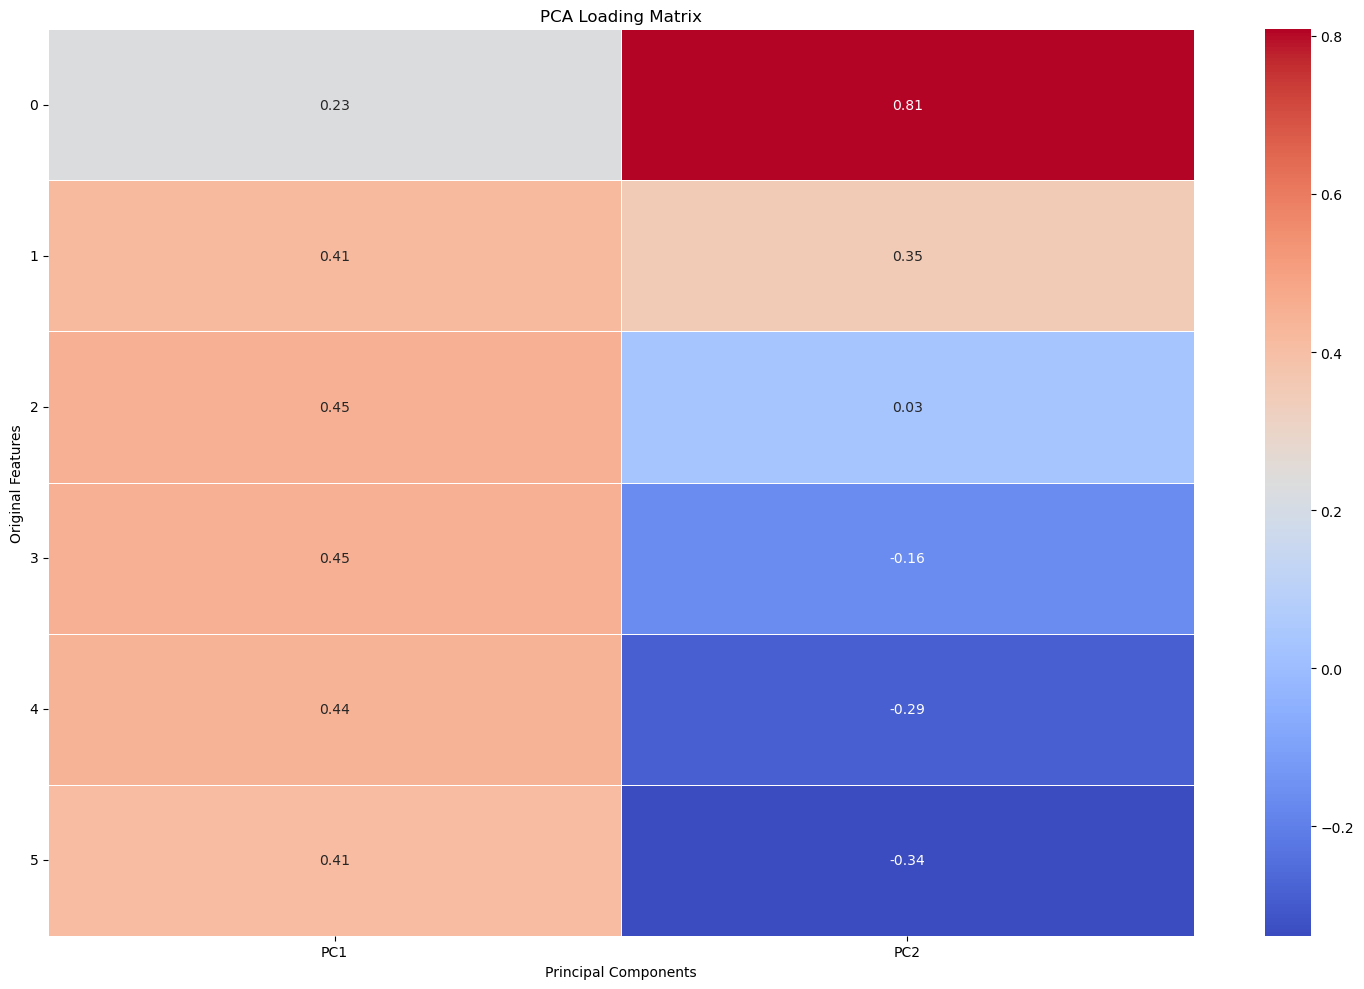

In [7]:
X_accel = df[['Accel.06miles', 'Accel.08miles', 'Accel.09miles', 'Accel.11miles', 'Accel.12miles', 'Accel.14miles']]
scaler = StandardScaler()
X_accel = scaler.fit_transform(X_accel)

X_brake = df[['Brake.06miles', 'Brake.08miles', 'Brake.09miles', 'Brake.11miles', 'Brake.12miles', 'Brake.14miles']]
scaler = StandardScaler()
X_brake = scaler.fit_transform(X_brake)

############
# 📌 6️⃣ PCA 적용 (n_components를 지정하지 않고 모든 주성분을 사용)
pca = PCA()
X_pca = pca.fit_transform(X_accel)

# 📌 7️⃣ 설명된 분산 비율 (Explained Variance Ratio)
explained_variance_ratio = pca.explained_variance_ratio_

# 📌 8️⃣ Elbow Plot 생성 (아래로 볼록한 형태)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Plot (Explained Variance Ratio of Principal Components)')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

# 📌 9️⃣ 주성분별 설명 분산 비율 출력
for i, variance in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: Explained Variance Ratio = {variance:.4f}")

##########
# 📌 n_components로 PCA 다시 수행
n_components = 2
pca = PCA(n_components=n_components)
accel_col = pca.fit_transform(X_accel)
preprocessed_df[['accel1', 'accel2']] = accel_col
preprocessed_df = preprocessed_df.drop(columns=['Accel.06miles', 'Accel.08miles', 'Accel.09miles', 'Accel.11miles', 'Accel.12miles', 'Accel.14miles'])

# 📌 주성분 계수 (loading) 시각화
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(n_components)])

# 📌 히트맵 시각화 (주성분에 대한 변수의 기여도)
plt.figure(figsize=(15, 10))  # 그래프 크기 확대
sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title('PCA Loading Matrix')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.yticks(rotation=0)  # y축 피처 이름을 가로로 회전
plt.tight_layout()  # 여백 자동 조정
plt.show()

##########
# 📌 n_components로 PCA 다시 수행
n_components = 2
pca = PCA(n_components=n_components)
brake_col = pca.fit_transform(X_brake)
preprocessed_df[['brake1', 'brake2']] = brake_col
preprocessed_df = preprocessed_df.drop(columns=['Brake.06miles', 'Brake.08miles', 'Brake.09miles', 'Brake.11miles', 'Brake.12miles', 'Brake.14miles'])

# 📌 주성분 계수 (loading) 시각화
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(n_components)])

In [8]:
preprocessed_df = preprocessed_df.drop(columns=['Pct.drive.wkday', 'Pct.drive.sat', 'Pct.drive.sun'])

X_drive = df[['Pct.drive.2hrs', 'Pct.drive.3hrs', 'Pct.drive.4hrs']]
scaler = StandardScaler()
X_drive = scaler.fit_transform(X_drive)

############
# 📌 n_components로 PCA 다시 수행
n_components = 1
pca = PCA(n_components=n_components)
pct_drive_hrs_col = pca.fit_transform(X_drive)
preprocessed_df[['pct_drive_hrs']] = pct_drive_hrs_col
preprocessed_df = preprocessed_df.drop(columns=['Pct.drive.2hrs', 'Pct.drive.3hrs', 'Pct.drive.4hrs'])

# 📌 주성분 계수 (loading) 시각화
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(n_components)])

In [9]:
categorical_cols = [
    'Insured.sex', 
    'Marital', 
    'Car.use', 
    'Region', 
    # 'Territory'  # 숫자로 되어있긴 하나, 범주형
]

numerical_cols = [
    'Territory',
    'Duration', 'Insured.age', 'Car.age', 'Credit.score', 
    'Annual.miles.drive', 'Years.noclaims', 'Annual.pct.driven', 
    'Total.miles.driven', 
    'Pct.drive.mon', 'Pct.drive.tue', 'Pct.drive.wed', 'Pct.drive.thr', 
    'Pct.drive.fri', 
    'pct_drive_hrs',
    'Pct.drive.wkend', 'Pct.drive.rush am', 'Pct.drive.rush pm', 
    'Avgdays.week', 
    'accel1', 'accel2', 'brake1', 'brake2',
    'left_turn_intensity', 'right_turn_intensity',
    'NB_Claim', 'AMT_Claim'
]

In [10]:
X_labeled = preprocessed_df[categorical_cols].copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_labeled[col] = le.fit_transform(X_labeled[col])
    
X_numerical = preprocessed_df[numerical_cols]

X_label_encoded = pd.concat([X_labeled, X_numerical], axis=1).astype(float)

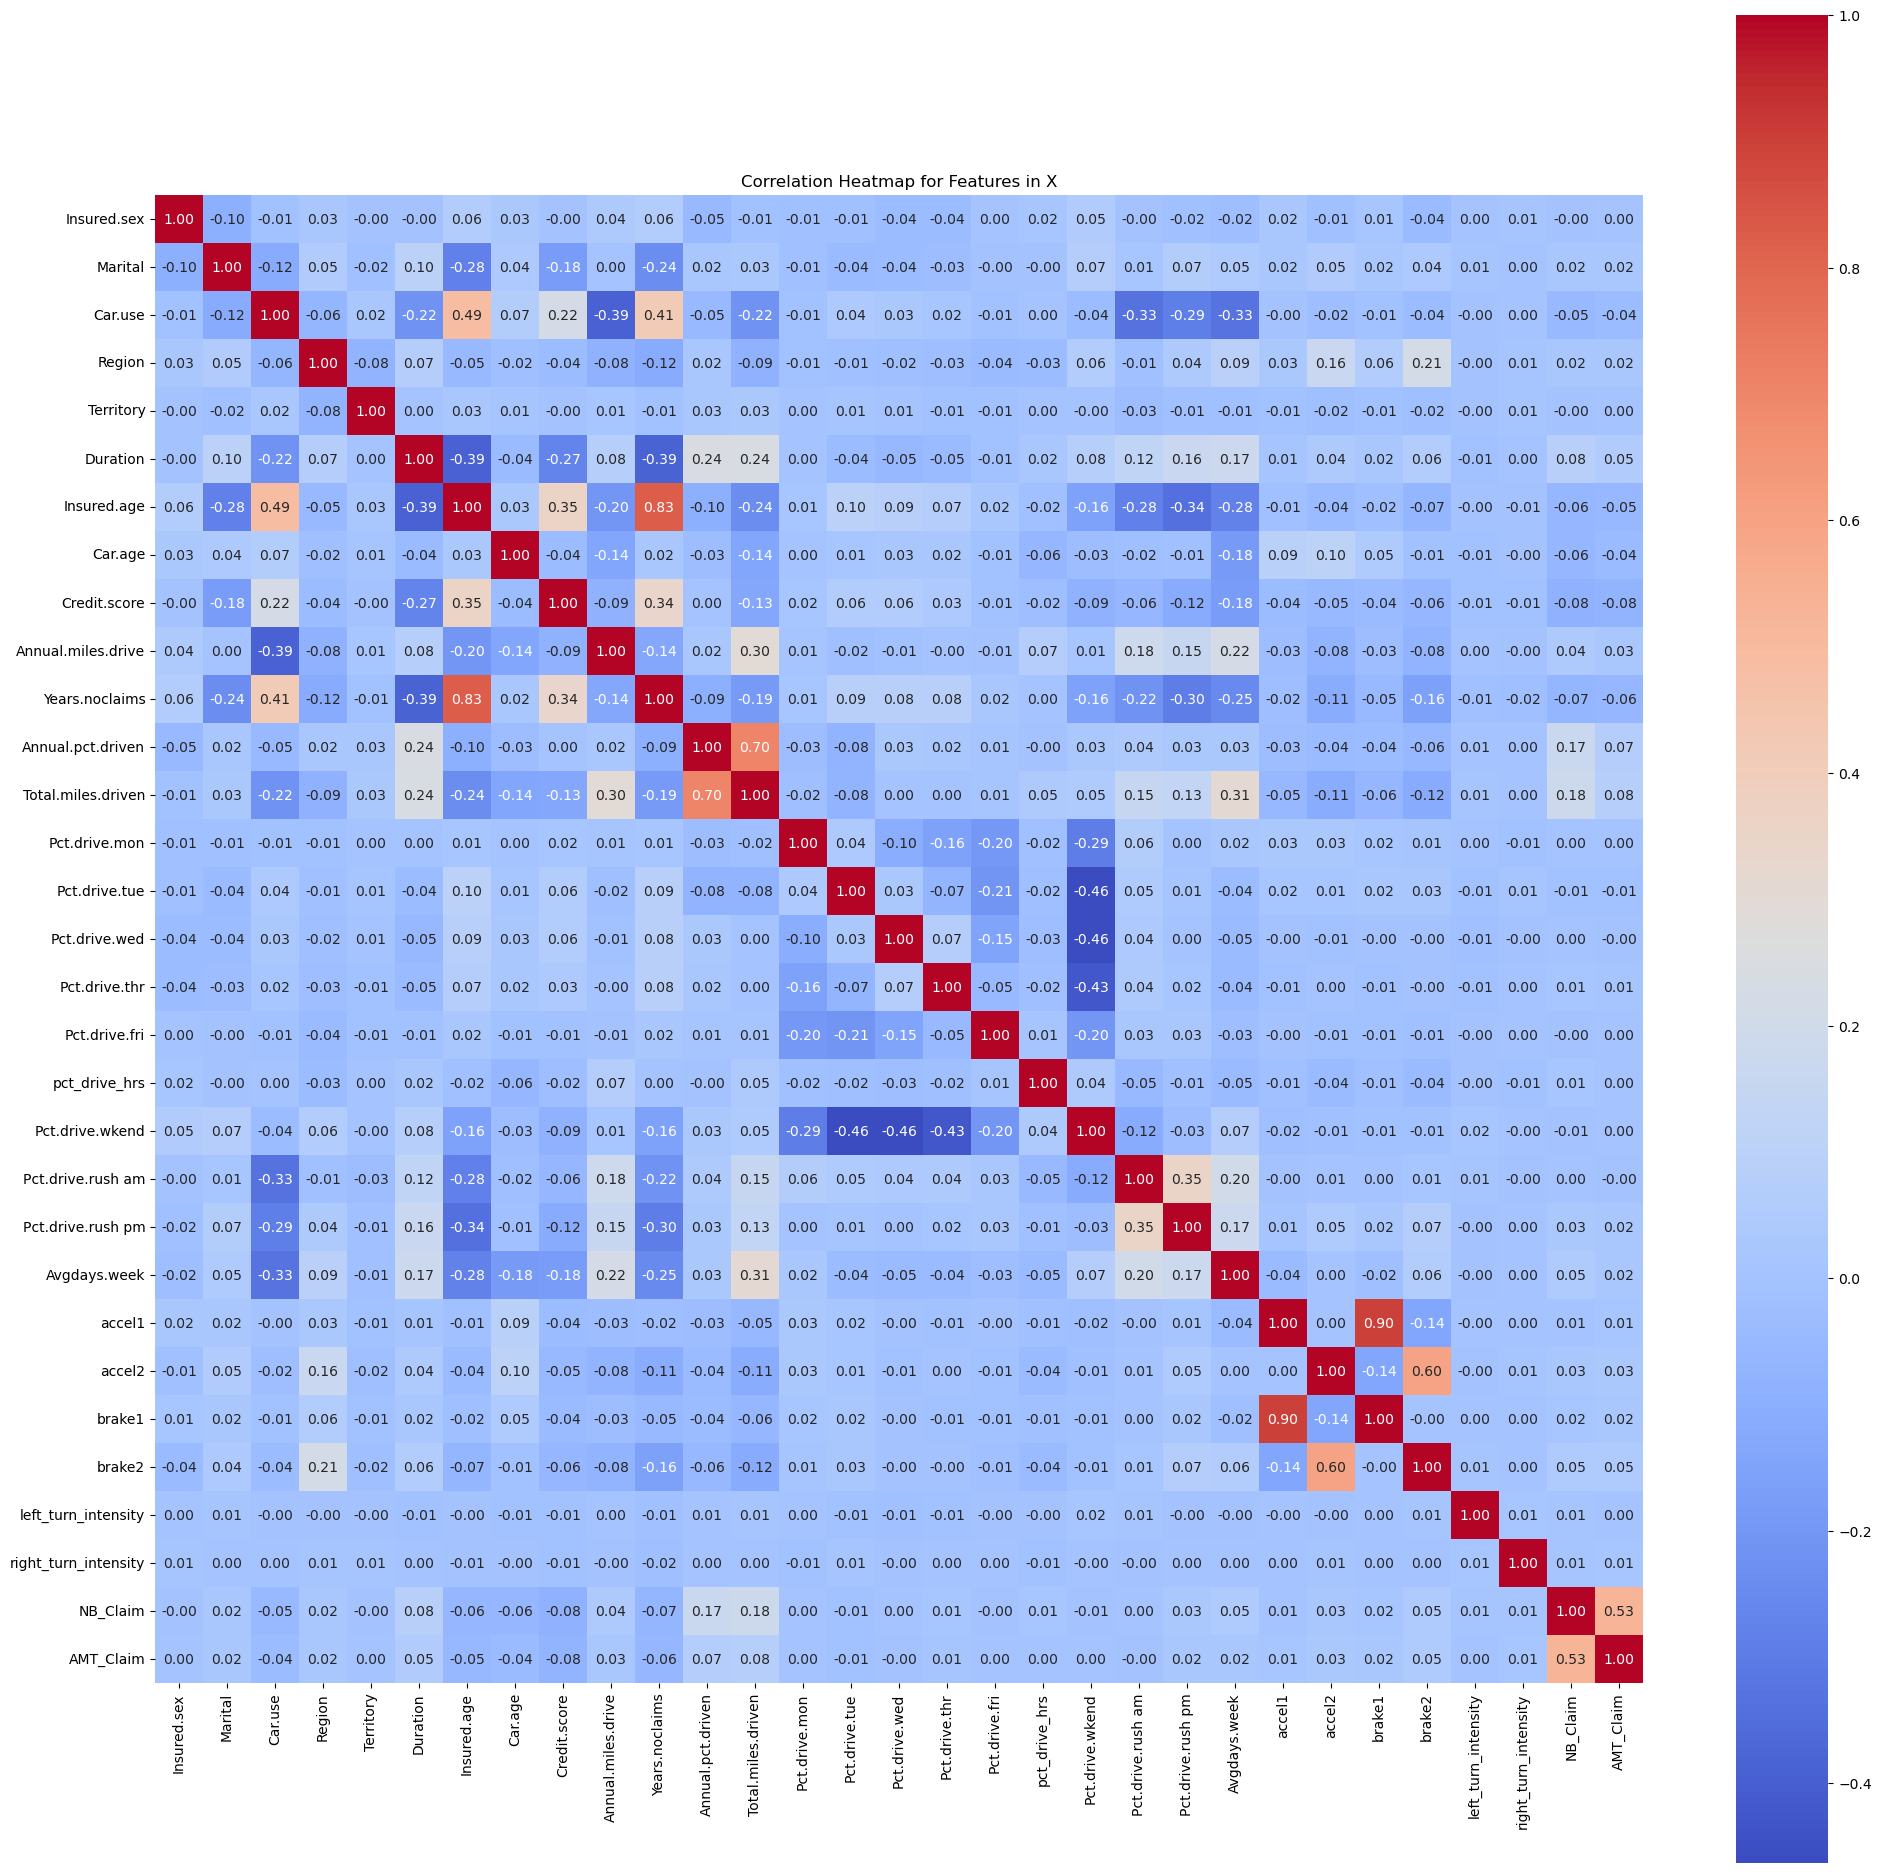

In [11]:
# 5️⃣ 상관 행렬 계산
correlation_matrix = X_label_encoded.corr()

# 히트맵 생성
plt.figure(figsize=(24, 24))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Heatmap for Features in X')
plt.show()

### 데이터 준비

In [12]:
categorical_cols = [
    'Insured.sex', 
    'Marital', 
    'Car.use', 
    'Region', 
    # 'Territory'  # 숫자로 되어있긴 하나, 범주형
]

numerical_cols = [
    'Territory',
    'Duration', 'Insured.age', 'Car.age', 'Credit.score', 
    'Annual.miles.drive', 'Years.noclaims', 'Annual.pct.driven', 
    'Total.miles.driven', 
    'Pct.drive.mon', 'Pct.drive.tue', 'Pct.drive.wed', 'Pct.drive.thr', 
    'Pct.drive.fri', 
    'pct_drive_hrs',
    'Pct.drive.wkend', 'Pct.drive.rush am', 'Pct.drive.rush pm', 
    'Avgdays.week', 
    'accel1', 'accel2', 'brake1', 'brake2',
    'left_turn_intensity', 'right_turn_intensity',
    'NB_Claim', 'AMT_Claim'
]

In [ ]:
X_labeled = preprocessed_df[categorical_cols].copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_labeled[col] = le.fit_transform(X_labeled[col])
    
X_dummy = pd.get_dummies(preprocessed_df[categorical_cols], drop_first=True)
X_numerical = preprocessed_df[numerical_cols].drop(columns=['NB_Claim', 'AMT_Claim'])

X_label_encoded = pd.concat([X_labeled, X_numerical], axis=1).astype(float)
X_dummy_encoded = pd.concat([X_dummy, X_numerical], axis=1).astype(float)

# Experiment 1

### Experiment 1.1 (Poisson)

#### 실험

                 Generalized Linear Model Regression Results                  
Dep. Variable:               NB_Claim   No. Observations:                80000
Model:                            GLM   Df Residuals:                    79968
Model Family:                 Poisson   Df Model:                           31
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12955.
Date:                Thu, 12 Dec 2024   Deviance:                       19003.
Time:                        23:45:18   Pearson chi2:                 7.75e+04
No. Iterations:                     9   Pseudo R-squ. (CS):            0.04514
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.3236 

/var/folders/yg/db8m6wq93qd3y4rp6b5_b0_w0000gn/T/ipykernel_56287/2701116034.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


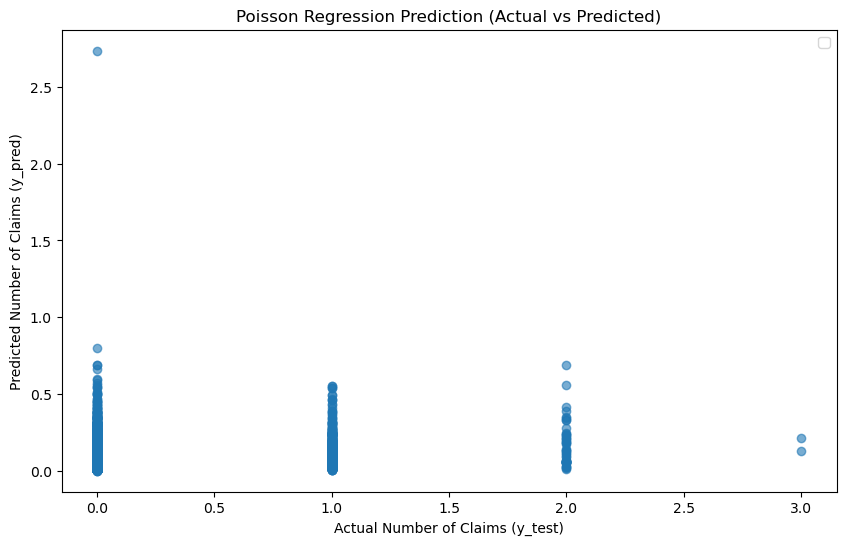

RMSE (Root Mean Squared Error): 0.2161


In [46]:
X = X_dummy_encoded
y = df['NB_Claim']  # 종속변수는 3년 동안 평균 사고 횟수

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# 상수항 추가
X_train = sm.add_constant(X_train) 
X_test = sm.add_constant(X_test)

# 포아송 회귀 모델 학습
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# 학습된 회귀 계수 확인
print(poisson_results.summary())

# 예측 수행
y_pred = poisson_results.predict(X_test)

# 7️⃣ 예측 값과 실제 값 비교 (시각화)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Number of Claims (y_test)')
plt.ylabel('Predicted Number of Claims (y_pred)')
plt.title('Poisson Regression Prediction (Actual vs Predicted)')
plt.legend()
plt.show()

# 8️⃣ 모델 성능 평가 (MAE, MSE 계산)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'RMSE (Root Mean Squared Error): {rmse:.4f}')

                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               NB_Claim   No. Observations:                80000
Model:                            GLM   Df Residuals:                    79968
Model Family:                 Poisson   Df Model:                           31
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12955.
Date:                Thu, 12 Dec 2024   Deviance:                       19003.
Time:                        23:45:18   Pearson chi2:                 7.75e+04
No. Iterations:                     9   Pseudo R-squ. (CS):            0.04514
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.3236      6.503     -0.357      0.721     -15.070      10.423
Insured.sex_Male         0.0521      0.034      1.523      0.128      -0.015       0.119
Marital_Single           0.0499      0.037      1.347      0.178      -0.023       0.122
Car.use_Commute         -0.0521      0.088     -0.592      0.554      -0.225       0.120
Car.use_Farmer          -0.4683      0.267     -1.757      0.079      -0.991       0.054
Car.use_Private         -0.0088      0.094     -0.093      0.926      -0.193       0.175
Region_Urban             0.0978      0.047      2.102      0.036       0.007       0.189
Territory               -0.0015      0.001     -2.111      0.035      -0.003      -0.000
Duration                 0.0014      0.000      3.997      0.000       0.001       0.002
Insured.age              0.0051      0.002      2.515      0.012       0.001       0.009
Car.age                 -0.0632      0.005    -13.333      0.000      -0.072      -0.054
Credit.score            -0.0030      0.000    -15.936      0.000      -0.003      -0.003
Annual.miles.drive    1.247e-05   4.81e-06      2.595      0.009    3.05e-06    2.19e-05
Years.noclaims          -0.0079      0.002     -4.147      0.000      -0.012      -0.004
Annual.pct.driven        2.2228      0.084     26.526      0.000       2.059       2.387
Total.miles.driven    3.891e-05   4.06e-06      9.578      0.000    3.09e-05    4.69e-05
Pct.drive.mon            0.6618      6.516      0.102      0.919     -12.110      13.434
Pct.drive.tue           -0.6746      6.513     -0.104      0.918     -13.440      12.091
Pct.drive.wed           -1.5905      6.515     -0.244      0.807     -14.360      11.179
Pct.drive.thr            1.3721      6.515      0.211      0.833     -11.397      14.141
Pct.drive.fri           -0.8503      6.519     -0.130      0.896     -13.628      11.928
pct_drive_hrs            0.0123      0.006      2.160      0.031       0.001       0.024
Pct.drive.wkend         -2.2130      6.494     -0.341      0.733     -14.941      10.515
Pct.drive.rush am       -2.0273      0.264     -7.691      0.000      -2.544      -1.511
Pct.drive.rush pm        1.0528      0.284      3.705      0.000       0.496       1.610
Avgdays.week             0.0645      0.020      3.269      0.001       0.026       0.103
accel1                  -0.0009      0.017     -0.050      0.960      -0.034       0.032
accel2                   0.0843      0.022      3.884      0.000       0.042       0.127
brake1                   0.0104      0.019      0.536      0.592      -0.028       0.049
brake2                   0.1581      0.024      6.667      0.000       0.112       0.205
left_turn_intensity      0.0128      0.005      2.701      0.007       0.003       0.022
right_turn_intensity     0.0088      0.004      2.159      0.031       0.001       0.017
========================================================================================

In [18]:
# 백테스트를 통한 기대손실 계산
nb_claim_test = preprocessed_df.loc[y_test.index, 'NB_Claim']
amt_claim_test = preprocessed_df.loc[y_test.index, 'AMT_Claim']

avgamt_claim = np.where(nb_claim_test > 0, amt_claim_test / nb_claim_test, 0)

expected_loss = y_pred*avgamt_claim  # Expected loss
total_loss = amt_claim_test  # Actual loss

# 11️ 백테스트 평가
total_predicted_loss = np.sum(expected_loss)
total_actual_loss = np.sum(total_loss)
loss_diff = np.abs(total_predicted_loss - total_actual_loss)

print(f'Total Expected Loss: {total_predicted_loss:.2f} $')
print(f'Total Actual Loss: {total_actual_loss:.2f} $')
print(f'Total Loss Difference: {loss_diff:.2f} $')

Total Expected Loss: 266929.22 $
Total Actual Loss: 2660571.51 $
Total Loss Difference: 2393642.29 $


### Experiment 1.2 (Cox)

#### 실험

<lifelines.CoxPHFitter: fitted with 80000 total observations, 76598 right-censored observations>
             duration col = 'Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 80000
number of events observed = 3402
   partial log-likelihood = -36526.85
         time fit was run = 2024-12-12 14:53:09 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Insured.sex_Male      0.07      1.07      0.04            0.00            0.14                1.00                1.15
Marital_Single        0.05      1.05      0.04           -0.02            0.13                0.98                1.14
Car.use_Commute      -0.03      0.97      0.09           -0.21            0.15                0.81                1.16
Car.use_Farmer       -0.43      0.65      0.27           -0.95            0.10                0.39                1.10
Car.use_Private       0.02      1.02      0.10           -0.17            0.21                0.84                1.23
Region_Urban          0.10      1.11      0.05            0.01            0.20                1.01                1.22
Territory            -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Duration              0.00      1.00      0.00            0.00            0.00                1.00                1.00
Insured.age           0.00      1.00      0.00           -0.00            0.01                1.00                1.01
Car.age              -0.07      0.93      0.00           -0.08           -0.06                0.93                0.94
Credit.score         -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Annual.miles.drive    0.00      1.00      0.00            0.00            0.00                1.00                1.00
Years.noclaims       -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
Annual.pct.driven     2.33     10.23      0.09            2.16            2.49                8.64               12.10
Total.miles.driven    0.00      1.00      0.00            0.00            0.00                1.00                1.00
Pct.drive.mon         3.56     35.22      6.69           -9.54           16.67                0.00            1.73e+07
Pct.drive.tue         2.39     10.89      6.68          -10.71           15.49                0.00            5.32e+06
Pct.drive.wed         1.26      3.51      6.69          -11.85           14.36                0.00            1.72e+06
Pct.drive.thr         4.50     89.69      6.68           -8.60           17.60                0.00            4.39e+07
Pct.drive.fri         2.05      7.77      6.69          -11.06           15.16                0.00            3.85e+06
pct_drive_hrs         0.01      1.01      0.01            0.00            0.02                1.00                1.02
Pct.drive.wkend       0.65      1.92      6.66          -12.41           13.71                0.00            9.02e+05
Pct.drive.rush am    -2.04      0.13      0.27           -2.57           -1.51                0.08                0.22
Pct.drive.rush pm     0.76      2.14      0.29            0.19            1.34                1.20                3.80
Avgdays.week          0.06      1.06      0.02            0.02            0.10                1.02                1.10
accel1               -0.00      1.00      0.02           -0.04            0.03                0.96                1.03
accel2                0.09      1.09      0.02            0.04            0.13                1.04                1.14
brake1                0.01      1.01      0.02           -0.03            0.05                0.97                1.05
brake2                0.16      1.17      0.02            0.11  

/var/folders/yg/db8m6wq93qd3y4rp6b5_b0_w0000gn/T/ipykernel_56287/586589234.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


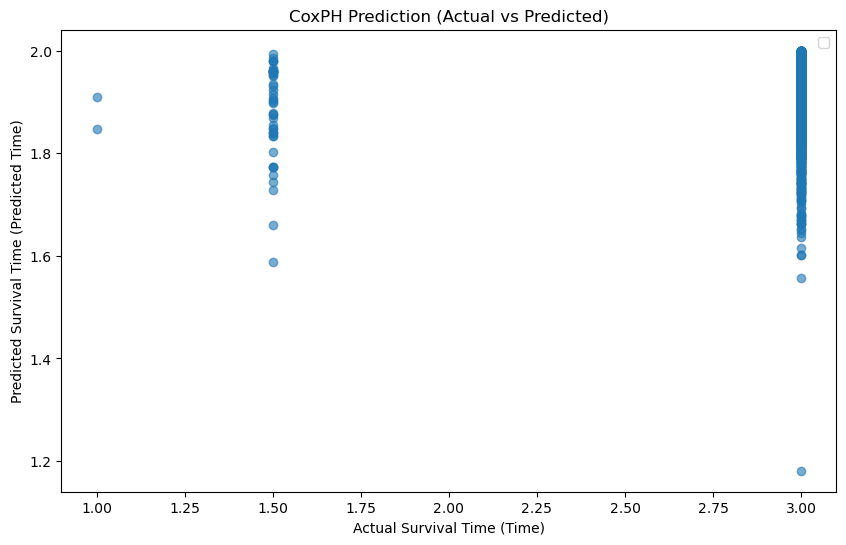

RMSE (Root Mean Squared Error): 1.0316


In [47]:
X = X_dummy_encoded
time_col = np.where(df['NB_Claim'] > 0, 3 / df['NB_Claim'], 3)  # NB_Claim이 0이면 3으로 설정
event_col = np.where(df['NB_Claim'] > 0, 1, 0)  # 사고가 발생했으면 Event=1, 그렇지 않으면 0
cox_df = pd.DataFrame({'Time': time_col, 'Event': event_col})

# 생존 분석용으로 Time과 Event 추가
df_final = pd.concat([X, cox_df], axis=1)

# 🔍 데이터 분할 (train / test)
train_df, test_df = train_test_split(df_final, test_size=0.2, random_state=seed)

# 🔍 콕스 비례위험모형 학습
cph = CoxPHFitter()
cph.fit(train_df, duration_col='Time', event_col='Event')

# 🔍 학습된 회귀 계수 확인
cph.print_summary()  # 회귀 계수, p-value, exp(coef) 확인

# 🔍 예측 수행 (테스트 데이터에 대해 예측)
# predict_expectation()은 생존 시간의 기대값을 예측
y_pred = cph.predict_expectation(test_df)

# 🔍 예측 값과 실제 값 비교 (시각화)
plt.figure(figsize=(10, 6))
plt.scatter(test_df['Time'], y_pred, alpha=0.6)
plt.xlabel('Actual Survival Time (Time)')
plt.ylabel('Predicted Survival Time (Predicted Time)')
plt.title('CoxPH Prediction (Actual vs Predicted)')
plt.legend()
plt.show()

# 🔍 모델 성능 평가 (RMSE 계산)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_df['Time'], y_pred))  # 실제 Time과 예측된 Time 비교
print(f'RMSE (Root Mean Squared Error): {rmse:.4f}')

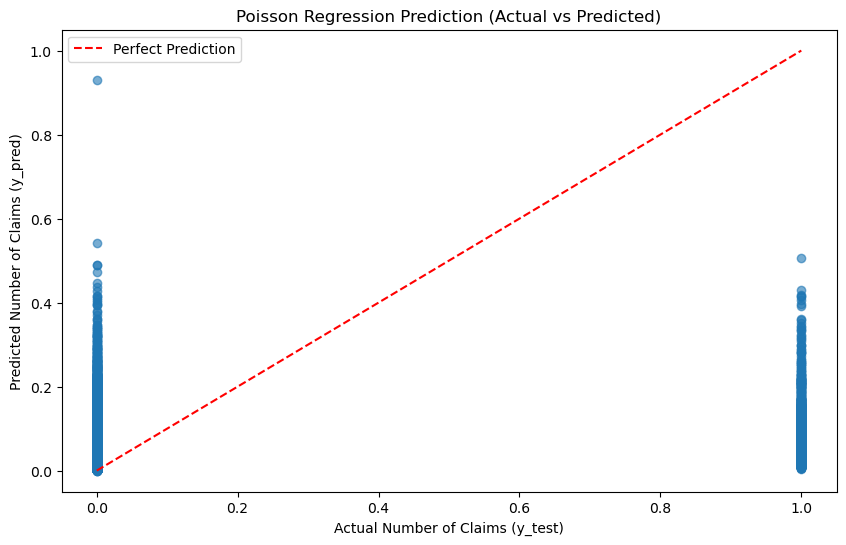

RMSE (Root Mean Squared Error): 0.1981


In [20]:
# 🔍 누적 위험 함수 H(t) 예측
cumulative_hazard = cph.predict_cumulative_hazard(test_df)
cumulative_hazard_mean = cumulative_hazard.iloc[-1, :]  # 각 관측치에 대해 평균 누적 위험

# 🔍 생존 확률 S(t) 계산
survival_probabilities = np.exp(-cumulative_hazard_mean)
# 🔍 사고 확률 p 계산
accident_probabilities = 1 - survival_probabilities

y_pred = accident_probabilities.values  # 사고 확률
y_test = test_df['Event']

# 7️⃣ 예측 값과 실제 값 비교 (시각화)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Number of Claims (y_test)')
plt.ylabel('Predicted Number of Claims (y_pred)')
plt.title('Poisson Regression Prediction (Actual vs Predicted)')
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.show()

# 8️⃣ 모델 성능 평가 (MAE, MSE 계산)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'RMSE (Root Mean Squared Error): {rmse:.4f}')

In [21]:
# 백테스트를 통한 기대손실 계산
nb_claim_test = preprocessed_df.loc[test_df.index, 'NB_Claim']
amt_claim_test = preprocessed_df.loc[test_df.index, 'AMT_Claim']

avgamt_claim = np.where(nb_claim_test > 0, amt_claim_test / nb_claim_test, 0)

expected_loss = y_pred*amt_claim_test  # Expected loss
total_loss = amt_claim_test  # Actual loss

# 11️ 백테스트 평가
total_predicted_loss = np.sum(expected_loss)
total_actual_loss = np.sum(total_loss)
loss_diff = np.abs(total_predicted_loss - total_actual_loss)

print(f'Total Expected Loss: {total_predicted_loss:.2f} $')
print(f'Total Actual Loss: {total_actual_loss:.2f} $')
print(f'Total Loss Difference: {loss_diff:.2f} $')

Total Expected Loss: 261093.51 $
Total Actual Loss: 2660571.51 $
Total Loss Difference: 2399478.00 $


### Experiment 1.3 (Maching Learning)

#### 실험

##### XGB

In [23]:
# 🔍 데이터 준비
X = X_label_encoded
y = pd.DataFrame(np.where(df['NB_Claim'] > 0, 1, 0))  # 종속변수는 사고 유무

# 🔍 데이터 분할 (train / test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)  # 🟢 random_state 추가

# 🔍 XGBoost 모델 초기화
xgb_model = XGBClassifier(random_state=seed)

# 🔍 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 개수
    'max_depth': [3, 5, 7],  # 최대 깊이
    'learning_rate': [0.01, 0.05, 0.1],  # 학습률
    'subsample': [0.6, 0.8, 1.0],  # 샘플링 비율
    'colsample_bytree': [0.6, 0.8, 1.0],  # 트리의 특성 샘플링 비율
}

# 🔍 GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # 평가 지표
    cv=3,  # 3-Fold 교차 검증
    n_jobs=-1,  # 모든 CPU 코어 사용
    verbose=2  # 상세한 진행 상태 출력
)

# 🔍 하이퍼파라미터 튜닝 수행
grid_search.fit(X_train, y_train)

# 🔍 최적의 하이퍼파라미터 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END 

In [28]:
import json
best_params = grid_search.best_params_
file_path = '/Users/choi/Documents/graduation/dissertation/code/data/best_params.json'
# 🔍 JSON 파일로 저장
with open(file_path, 'w') as file:
    json.dump(best_params, file)

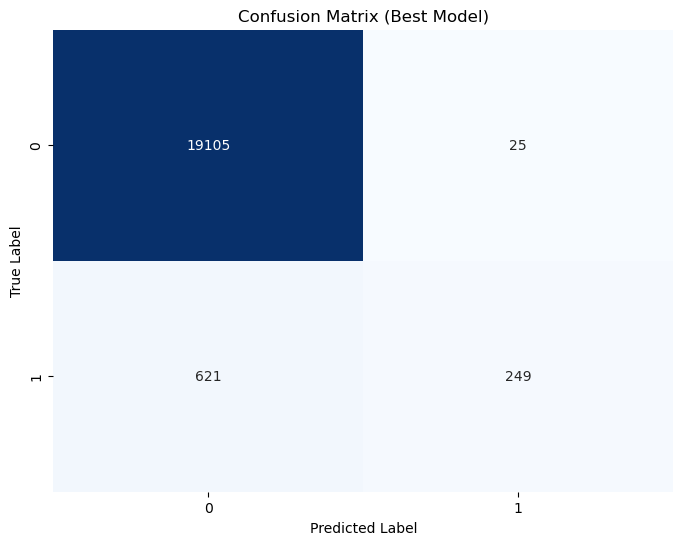

Accuracy: 0.9677
Precision: 0.9088
Recall: 0.2862
F1-Score: 0.4353


In [29]:
# 🔍 1️⃣ JSON 파일에서 하이퍼파라미터 불러오기
file_path = '/Users/choi/Documents/graduation/dissertation/code/data/best_params.json'

with open(file_path, 'r') as file:
    best_params = json.load(file)

xgb_model = XGBClassifier(**best_params, random_state=seed)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# 🔍 혼동 행렬 계산 및 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Best Model)')
plt.show()

# 🔍 최적의 모델로 성능 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 📌 성능 출력
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

In [30]:
# 백테스트를 통한 기대손실 계산
nb_claim_test = preprocessed_df.loc[y_test.index, 'NB_Claim']
amt_claim_test = preprocessed_df.loc[y_test.index, 'AMT_Claim']

avgamt_claim = np.where(nb_claim_test > 0, amt_claim_test / nb_claim_test, 0)

expected_loss = y_pred_prob*amt_claim_test  # Expected loss
total_loss = amt_claim_test  # Actual loss

# 11️ 백테스트 평가
total_predicted_loss = np.sum(expected_loss)
total_actual_loss = np.sum(total_loss)
loss_diff = np.abs(total_predicted_loss - total_actual_loss)

print(f'Total Expected Loss: {total_predicted_loss:.2f} $')
print(f'Total Actual Loss: {total_actual_loss:.2f} $')
print(f'Total Loss Difference: {loss_diff:.2f} $')

Total Expected Loss: 957597.15 $
Total Actual Loss: 2660571.51 $
Total Loss Difference: 1702974.36 $


##### 랜덤포레스트

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


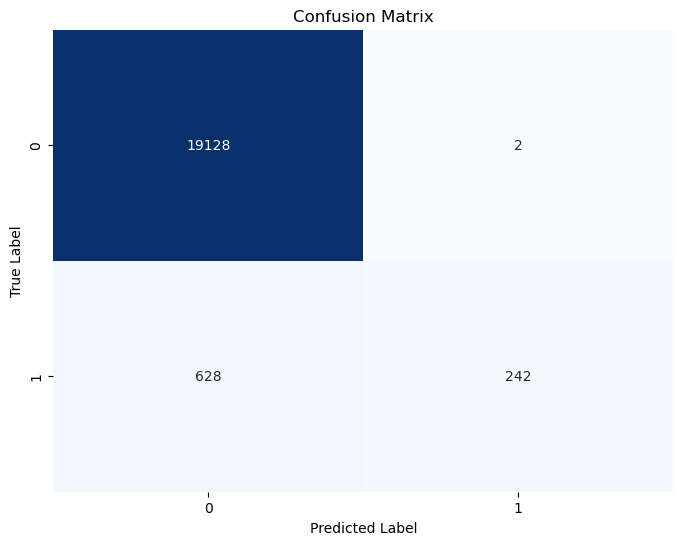

Accuracy: 0.9685
Precision: 0.9918
Recall: 0.2782
F1-Score: 0.4345


In [ ]:
X = X_label_encoded
y = pd.DataFrame(np.where(df['NB_Claim'] > 0, 1, 0))  # 종속변수는 사고 유무 (0 또는 1)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Random Forest 모델 학습
rf_model = RandomForestClassifier(random_state=seed)
rf_model.fit(X_train, y_train)

# 학습된 모델로 예측 수행
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # ROC-AUC 점수를 위한 확률값

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 8️⃣ 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 성능 출력
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

In [ ]:
# 백테스트를 통한 기대손실 계산
nb_claim_test = preprocessed_df.loc[y_test.index, 'NB_Claim']
amt_claim_test = preprocessed_df.loc[y_test.index, 'AMT_Claim']

avgamt_claim = np.where(nb_claim_test > 0, amt_claim_test / nb_claim_test, 0)

expected_loss = y_pred_prob*amt_claim_test  # Expected loss
total_loss = amt_claim_test  # Actual loss

# 11️ 백테스트 평가
total_predicted_loss = np.sum(expected_loss)
total_actual_loss = np.sum(total_loss)
loss_diff = np.abs(total_predicted_loss - total_actual_loss)

print(f'Total Expected Loss: {total_predicted_loss:.2f} $')
print(f'Total Actual Loss: {total_actual_loss:.2f} $')
print(f'Total Loss Difference: {loss_diff:.2f} $')

Total Expected Loss: 973667.54 $
Total Actual Loss: 2660571.51 $
Total Loss Difference: 1686903.97 $


# Experiment 2

### SHAP

In [32]:
# 4️⃣ SHAP 값 계산 (XGBoost)
explainer_xgb = shap.Explainer(xgb_model, X_test)
shap_values_xgb = explainer_xgb(X_test)

100%|===================| 19953/20000 [03:37<00:00]        

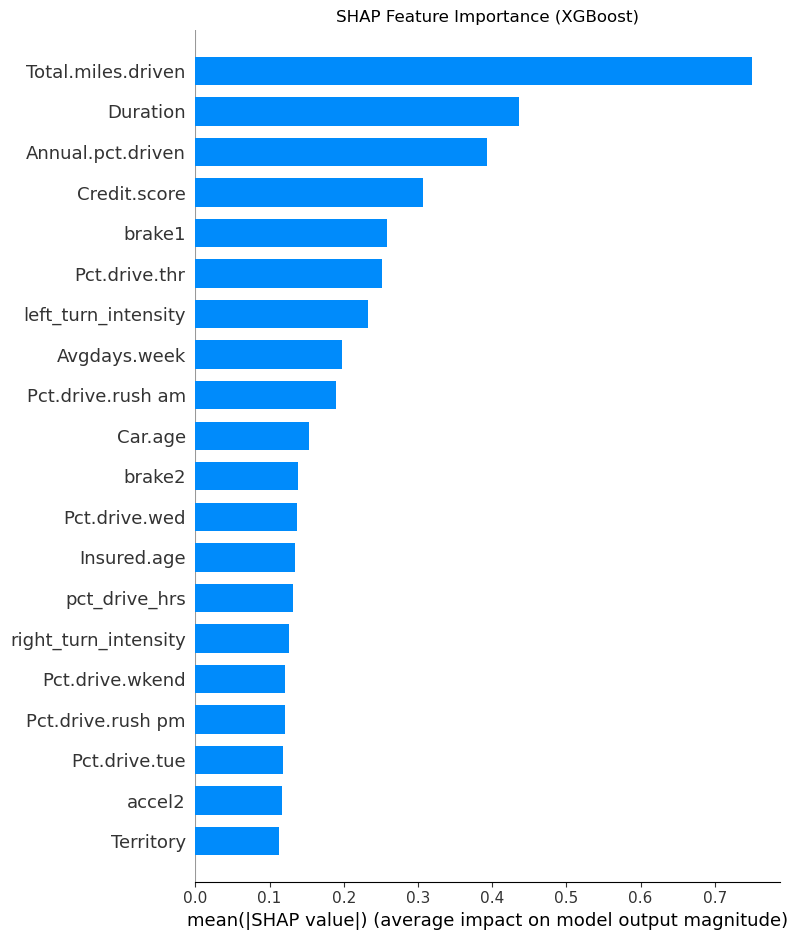

In [37]:
# SHAP 값 시각화 (XGBoost)
plt.title('SHAP Feature Importance (XGBoost)')
shap.summary_plot(shap_values_xgb, X_test, plot_type='bar', show=True)

In [36]:
# 2️⃣ SHAP 값의 절대값을 통해 가장 중요한 변수 찾기
shap_values_df = pd.DataFrame(shap_values_xgb.values, columns=X_test.columns)  # SHAP 값을 DataFrame으로 변환
most_important_features = shap_values_df.abs().idxmax(axis=1)  # 각 샘플별로 가장 절대값이 큰 SHAP 값의 변수명 반환

# 3️⃣ X_test 복사본 생성 (원본 데이터 손상 방지)
X_modified = X_test.copy()

# 4️⃣ 각 샘플의 가장 중요한 변수의 값을 1씩 감소
for i, feature in enumerate(most_important_features):
    if feature in X_modified.columns:  # 주요 변수의 값이 실제 컬럼에 있는지 확인
        X_modified.loc[X_modified.index[i], feature] -= 1  # 해당 샘플의 주요 변수 값을 1 감소

# 5️⃣ 결과 확인 (변경 전후의 데이터 비교)
print(f"🔍 원본 X_test의 첫 번째 샘플\n{X_test.iloc[0]}")
print(f"🔍 수정된 X_modified의 첫 번째 샘플\n{X_modified.iloc[0]}")

# 6️⃣ 주요 변수와 그에 대한 변화 확인
# lookup 대신 zip을 활용해 값을 가져옵니다.
original_values = [X_test.loc[idx, feature] for idx, feature in zip(X_test.index, most_important_features)]
new_values = [X_modified.loc[idx, feature] for idx, feature in zip(X_modified.index, most_important_features)]

# 7️⃣ 상위 10개의 샘플에 대해 주요 변수의 변화 확인
result_df = pd.DataFrame({
    'Original Value': original_values,
    'New Value': new_values,
    'Feature': most_important_features.values
})

# 상위 10개의 주요 변수의 변화 확인
result_df.tail()

🔍 원본 X_test의 첫 번째 샘플
Insured.sex                1.000000
Marital                    0.000000
Car.use                    3.000000
Region                     0.000000
Territory                 84.000000
Duration                 182.000000
Insured.age               63.000000
Car.age                   15.000000
Credit.score             845.000000
Annual.miles.drive      6213.710000
Years.noclaims            46.000000
Annual.pct.driven          0.446575
Total.miles.driven      1482.557728
Pct.drive.mon              0.156765
Pct.drive.tue              0.237472
Pct.drive.wed              0.157207
Pct.drive.thr              0.141442
Pct.drive.fri              0.116827
pct_drive_hrs             -0.449926
Pct.drive.wkend            0.186167
Pct.drive.rush am          0.090222
Pct.drive.rush pm          0.140222
Avgdays.week               2.223880
accel1                    -0.377434
accel2                    -0.576702
brake1                    -0.186315
brake2                    -0.546281
left_tu

,Original Value,New Value,Feature
19995,12471.560779,12470.560779,Total.miles.driven
19996,183.000000,182.000000,Duration
19997,4496.715046,4495.715046,Total.miles.driven
19998,1494.375713,1493.375713,Total.miles.driven
19999,181.000000,180.000000,Duration


### Adjust variable and calculate expected loss

In [39]:
y_pred_modified = xgb_model.predict(X_modified)
y_pred_prob_modified = xgb_model.predict_proba(X_modified)[:, 1]


# 백테스트를 통한 기대손실 계산
nb_claim_test = preprocessed_df.loc[y_test.index, 'NB_Claim']
amt_claim_test = preprocessed_df.loc[y_test.index, 'AMT_Claim']

avgamt_claim = np.where(nb_claim_test > 0, amt_claim_test / nb_claim_test, 0)

expected_loss = y_pred_prob*amt_claim_test  # Expected loss before adjustment
expected_loss_modified = y_pred_prob_modified*amt_claim_test  # Expected loss after adjustment

# 11️ 백테스트 평가
total_expected_loss = np.sum(expected_loss)
total_expected_loss_modified = np.sum(expected_loss_modified)

print(f'Total Expected Loss: {total_expected_loss:.2f} $')
print(f'Total Expected Loss: {total_expected_loss_modified:.2f} $')

Total Expected Loss: 957597.15 $
Total Expected Loss: 828817.93 $


# Experiment 3

### k-means

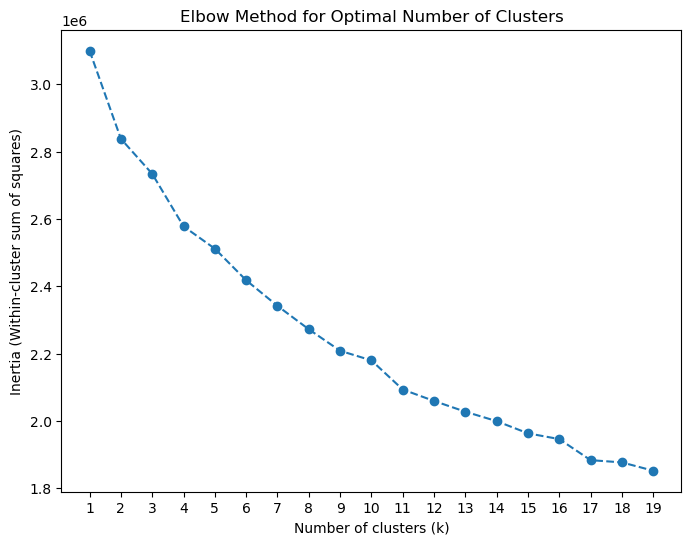

Cluster counts: 
Cluster
7     18401
1     18064
0     17135
2     17005
5     16309
4      5063
10     4140
8      3686
6       105
9        51
3        41
Name: count, dtype: int64
Cluster Centers: 
    Insured.sex   Marital   Car.use    Region  Territory  Duration  \
0      0.085856 -0.369792 -0.793004 -0.022626  -0.044767 -0.005632   
1      0.043250 -0.220106  0.852331 -0.079316   0.059591  0.617819   
2     -0.047917  0.037177 -0.579740 -0.033184   0.043093  0.611357   
3      0.728286  0.142082  0.063541  0.056784   0.031673  0.035978   
4      0.281701  0.106217  0.419796  0.004335  -0.039382  0.112917   
5     -0.175771  0.856773 -0.442035  0.212934  -0.049761  0.351722   
6      0.102411  0.154240 -0.005367 -0.162415  -0.066089 -0.317488   
7      0.008281 -0.297011  0.763403 -0.177480   0.010050 -1.609792   
8     -0.047291  0.035893  0.029259  0.454130  -0.058275  0.033477   
9      0.373283 -0.014354 -0.008091  0.054469   0.460820  0.313888   
10    -0.007385  0.111197 -0.

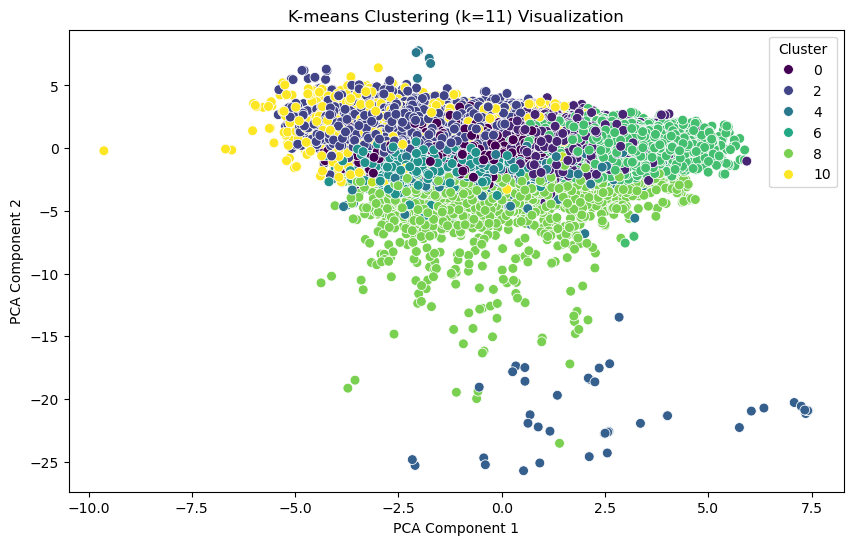

Final DataFrame with Clusters: 
   Insured.sex  Marital  Car.use  Region  Territory  Duration  Insured.age  \
0          1.0      0.0      1.0     1.0       70.0     366.0         45.0   
1          0.0      0.0      1.0     1.0       26.0     182.0         44.0   
2          0.0      0.0      1.0     1.0       84.0     184.0         48.0   
3          1.0      0.0      3.0     1.0       30.0     183.0         71.0   
4          1.0      0.0      3.0     1.0       70.0     183.0         84.0   

   Car.age  Credit.score  Annual.miles.drive  ...  Avgdays.week    accel1  \
0     -1.0         609.0             6213.71  ...      6.528897 -0.102319   
1      3.0         575.0            12427.42  ...      6.500000  0.153308   
2      6.0         847.0            12427.42  ...      5.388865  1.486065   
3      6.0         842.0             6213.71  ...      5.148138 -0.288185   
4     10.0         856.0             6213.71  ...      6.482803 -0.054696   

     accel2    brake1    brake2  lef

In [ ]:
from sklearn.cluster import KMeans

X_labeled = preprocessed_df[categorical_cols].copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_labeled[col] = le.fit_transform(X_labeled[col])
    
X_numerical = preprocessed_df[numerical_cols]
X_label_encoded = pd.concat([X_labeled, X_numerical], axis=1).astype(float)


# 🔍 스케일링 (K-means는 거리 기반 알고리즘이므로 스케일링 필수)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_label_encoded)

# 🔍 엘보우 방법을 사용하여 최적의 클러스터 개수 찾기
inertia = []  # 각 클러스터 개수에 대한 inertia(거리합) 저장
K_range = range(1, 20)  # 클러스터 개수 1~10에 대해 테스트

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 🔍 엘보우 플롯 그리기
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(K_range)
plt.show()


##############

# 🔍 최적의 k 값 설정 (엘보우 플롯을 보고 결정)
optimal_k = 11  # 🔥 필요에 따라 최적의 k 수정

# 🔍 K-means 클러스터링 수행
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
X_label_encoded['Cluster'] = kmeans.fit_predict(X_scaled)  # 🔥 클러스터 할당 (라벨 추가)

# 🔍 클러스터별 샘플 개수 확인
cluster_counts = X_label_encoded['Cluster'].value_counts()
print(f"Cluster counts: \n{cluster_counts}")

# 🔍 클러스터의 중심 좌표 확인
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=X_label_encoded.drop(columns='Cluster').columns)
print(f"Cluster Centers: \n{cluster_centers}")

##############

# 클러스터링된 각 그룹에 대해 AMT_Claim의 분산 계산
cluster_variances = X_label_encoded.groupby('Cluster')['AMT_Claim'].var()
all_variances = X_label_encoded['AMT_Claim'].var()


# 결과 출력
print("Variance of AMT_Claim for each cluster:")
print(cluster_variances)

print("Variance of AMT_Claim for all data:")
print(all_variances)

# ################

# 🔍 클러스터링 결과 시각화 (2D PCA로 차원 축소 후 시각화)
pca = PCA(n_components=2)  # 2차원 시각화를 위해 차원 축소
X_pca = pca.fit_transform(X_scaled)

# 🔍 클러스터 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X_label_encoded['Cluster'], palette='viridis', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'K-means Clustering (k={optimal_k}) Visualization')
plt.legend(title='Cluster')
plt.show()

# 🔍 최종 데이터셋 (클러스터 라벨이 추가된 데이터)
final_df = X_label_encoded.copy()
final_df['Cluster'] = X_label_encoded['Cluster']

# 🔍 최종 데이터프레임 확인
print(f"Final DataFrame with Clusters: \n{final_df.head()}")

In [56]:
print(cluster_variances.sum())

36742179.88142384


In [57]:
957597-828817

128780